**ML Pipeline Preparation**

**1. Import libraries and load data from database.**

In [10]:
# import libraries
import time
import pickle
import string
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

import re

import nltk
nltk.download(['punkt','wordnet','averaged_perceptron_tagger','stopwords'])
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score,make_scorer,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table("DisasterResponse", engine)

In [4]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df['message']
y = df.iloc[:,4:]

In [6]:

X[:20]

0     Weather update - a cold front from Cuba that c...
1               Is the Hurricane over or is it not over
2                       Looking for someone but no name
3     UN reports Leogane 80-90 destroyed. Only Hospi...
4     says: west side of Haiti, rest of the country ...
5                Information about the National Palace-
6                        Storm at sacred heart of jesus
7     Please, we need tents and water. We are in Sil...
8       I would like to receive the messages, thank you
9     I am in Croix-des-Bouquets. We have health iss...
10    There's nothing to eat and water, we starving ...
11    I am in Petionville. I need more information r...
12    I am in Thomassin number 32, in the area named...
13    Let's do it together, need food in Delma 75, i...
14    More information on the 4636 number in order f...
15    A Comitee in Delmas 19, Rue ( street ) Janvier...
16    We need food and water in Klecin 12. We are dy...
17    are you going to call me or do you want me

**tokenization function to process text data**

In [7]:
print(X[0])

Weather update - a cold front from Cuba that could pass over Haiti


In [11]:
def tokenize(text):
    table = text.maketrans(dict.fromkeys(string.punctuation))
    words = word_tokenize(text.lower().strip().translate(table))
    words = [word for word in words if word not in stopwords.words('english')]
    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]
    lemmed = [WordNetLemmatizer().lemmatize(word, pos='v') for word in lemmed]
    stemmed = [PorterStemmer().stem(word) for word in lemmed]
    
    return stemmed

In [12]:
tokenize(X[0])

['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pa', 'haiti']

**3.  a machine learning pipeline**

In [14]:

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(time.time() - time_begin)

526.8041746616364


In [17]:
y_pred = pipeline.predict(X_test)

In [18]:
metrics_test=precision_recall_fscore_support(y_test.iloc[:,0],y_pred[:,0],average='weighted')
metrics_test

(0.8068554889300036, 0.8180421084985401, 0.7963086587144623, None)

**Scoring function**

In [20]:
def metrics(y_true, y_pred):
    labels = []
    precision=[]
    recall=[]
    fbeta_score=[]
    accuracy=[]
    
    target_names=['class0','class1']  
    
    
    for i in range(y_true.shape[1]):
        labels.append(y_true.columns.tolist()[i])
        
        report=classification_report(y_true.iloc[:,i],y_pred[:,i], target_names=target_names)
        
        precision.append(float(report[-40:-30].strip()))
        recall.append(float(report[-30:-20].strip()))
        fbeta_score.append(float(report[-20:-10].strip()))
        
        accuracy.append(accuracy_score(y_true.iloc[:,i],y_pred[:,i]))
    
    
    metrics_df = pd.DataFrame(data = {'Precision':precision,'Recall':recall,'F1-Score':fbeta_score, 'Accuracy': accuracy}, index = labels)
    return metrics_df

In [21]:
metrics_df = metrics(y_test, y_pred)
print("F1 score mean : ", metrics_df['F1-Score'].mean())
metrics_df

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score mean :  0.9334285714285715


,Precision,Recall,F1-Score,Accuracy
related,0.81,0.82,0.80,0.818042
request,0.89,0.90,0.89,0.895805
offer,0.99,1.00,0.99,0.996004
aid_related,0.79,0.79,0.78,0.786538
medical_help,0.90,0.92,0.89,0.919779
medical_products,0.94,0.95,0.93,0.949439
search_and_rescue,0.96,0.97,0.96,0.970954
security,0.98,0.98,0.97,0.979714
military,0.96,0.97,0.95,0.966190
water,0.95,0.95,0.94,0.954357


We got average of 0.93  f1 score

Let's plot F1-score of every classes.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


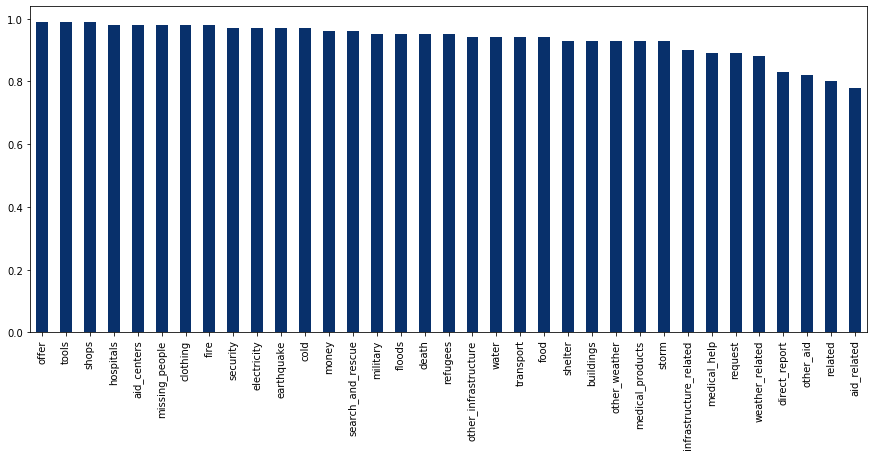

In [31]:
plt.figure(figsize=[15,6])
metrics_df['F1-Score'].sort_values(ascending=False).plot("bar", colormap="Blues_r")

**Additional features**

Number of words in sentences

In [22]:
class WordCount(BaseEstimator, TransformerMixin):
    def word_count(self, text):
        table = text.maketrans(dict.fromkeys(string.punctuation))
        words = word_tokenize(text.lower().strip().translate(table))
        return len(words)
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        count = pd.Series(x).apply(self.word_count)
        return pd.DataFrame(count)

Number of characters

In [23]:
class CharacterCount(BaseEstimator, TransformerMixin):
    def character_count(self, text):
        return len(text)
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        count = pd.Series(x).apply(self.character_count)
        return pd.DataFrame(count)

Nount count

In [24]:
class NounCount(BaseEstimator, TransformerMixin):
    def noun_count(self, text):
        count = 0
        sentence_list = sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            for _, tag in pos_tags:
                if tag in ['PRP', 'NN']:
                    count += 1
        
        return count
            
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        count = pd.Series(x).apply(self.noun_count)
        return pd.DataFrame(count)

verb count

In [25]:
class VerbCount(BaseEstimator, TransformerMixin):
    def verb_count(self, text):
        count = 0
        sentence_list = sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            for word, tag in pos_tags:
                if tag in ['VB', 'VBP']:
                    count += 1
        
        return count
            
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        count = pd.Series(x).apply(self.verb_count)
        return pd.DataFrame(count)

In [26]:
pipeline1 = Pipeline([
    ("features", FeatureUnion([
        ("text", TfidfVectorizer(tokenizer=tokenize)),
        ("word_count", WordCount()),
        ("character_count", CharacterCount()),
        ("noun_count", NounCount()),
        ("verb_count", VerbCount())
    ])),
    ("clf", MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])

In [27]:
time_begin = time.time()
pipeline1.fit(X_train, y_train)
print(time.time() - time_begin)

655.5201842784882


In [28]:
y_pred1 = pipeline1.predict(X_test)
metrics_df1 = metrics(y_test, y_pred1)
print("F1 score mean : ", metrics_df1['F1-Score'].mean())
metrics_df1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score mean :  0.9319999999999999


,Precision,Recall,F1-Score,Accuracy
related,0.81,0.81,0.78,0.812510
request,0.89,0.90,0.89,0.897034
offer,0.99,1.00,0.99,0.996004
aid_related,0.78,0.79,0.78,0.785308
medical_help,0.90,0.92,0.89,0.919779
medical_products,0.95,0.95,0.93,0.950515
search_and_rescue,0.96,0.97,0.96,0.971108
security,0.97,0.98,0.97,0.979560
military,0.96,0.97,0.95,0.966344
water,0.95,0.95,0.94,0.954357


oops adding additional features didn't help.

 **Improving  model with Girdsearch**

In [29]:
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
       # 'vect__max_df': (0.5, 1.0),
        #'vect__max_features': (None, 5000),
       # 'tfidf__use_idf': (True, False),
        # 'clf__estimator__max_features': ['log2','auto', 'sqrt'],
        'clf__estimator__n_estimators': [200, 500,600,800],
        # 'clf__estimator__max_depth': [4,6,8],
        'clf__estimator__min_samples_split': [0.1, 2, 4],
        # 'clf__estimator__min_samples_leaf': [2,10,30]
    }

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2, n_jobs=-1)

In [30]:
time_begin = time.time()
tuned_model = cv.fit(X_train, y_train)
print(time.time() - time_begin)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
tuned_model.best_params_

In [ ]:
y_pred_tuned = tuned_model.predict(X_test)

In [ ]:
metrics_df_tuned = metrics(y_test, y_pred_tuned)
print("F1 score mean : ", metrics_df_tuned['F1-Score'].mean())
metrics_df_tuned